# 18.369 pset 4 solutions

Solutions for the MPB calculations in pset 4, in the form of a Jupyter notebook. 

In [1]:
# do inline plots with Python's matplotlib library
from matplotlib import pyplot as plt
import numpy as np
import math

# load the Meep and MPB modules in Python
import meep as mp
from meep import mpb
mp.Verbosity(0) # suppress some of the text output

Verbosity: level=1

## Problem 2: Band gaps in MPB

The following code computes and plots the band diagram of a 1d-periodic structure, consisting of layers of two materials $\varepsilon_1 = 12$ and $\varepsilon_2 = 1$ with thicknesses $d_1$ and $d_2 = a - d_1$, respectively.

In 1d, both polarizations are equivalent, so we compute the "TM" ($E_z$ polarization) band structure only.  The following code computes it for $d_1 = 0.4a$, where we have a period $a=1$:

In [ ]:
eps1 = 12
eps2 = 1
d1 = 0.4
d2 = 1 - d1

ms = mpb.ModeSolver(                    
                    # unit cell is just size 1 in x direction (and zero size in y and z).
                    geometry_lattice=mp.Lattice(size=(1,0,0)),
                    
                    # we could define the unit cell by two objects (eps1 and eps2), but it
                    # is easier just to set the default material to eps2 and then add one
                    # object for eps1.
                    geometry=[mp.Block(center=(0,0,0), size=(d1,mp.inf,mp.inf),
                                       material=mp.Medium(epsilon=eps1))],
                    default_material=mp.Medium(epsilon=eps2),
    
                    # Let's set up the k points we want to compute.  Actually, to get the
                    # band gap we really only need k = pi/a, but we'll compute a range
                    # of k's in the irreducible Brillouin zone just so that we can make
                    # nice plots if we want.  Note that k is in units of 2pi/a, so, k=pi/a
                    # is just given as k=0.5.
                    k_points=mp.interpolate(9, [mp.Vector3(0), mp.Vector3(0.5)]),
                    
                    resolution=32, # this is plenty for the first few bands
                    num_bands=5 # the number of bands to compute (you may want more or less)
                    )

ms.run_tm() # TM and TE are equivalent in 1d, so we'll just do TM

### part (a)

Now, we compute the (fractional) gap size as a function of $d_1$.  We'll use a loop to compute the gap sizes for a bunch of $d_1$ values from $d_1 = 0$ to $d_1 = 1$, where of course the gap size should be zero at the endpoints.

In [ ]:
# 20 points in [0,1)
d1s = np.linspace(0,1,20,endpoint=False) 

ms.num_bands = 2 # we only need 2 bands for the gap

gaps = []
for d1 in d1s:
    ms.geometry=[mp.Block(center=(0,0,0), size=(d1,mp.inf,mp.inf),
                          material=mp.Medium(epsilon=eps1))]
    ms.run_tm()
    gap_bottom = ms.all_freqs[-1,0]  
    gap_top =    ms.all_freqs[-1,1]
    gap = 100 * (gap_top - gap_bottom) / (0.5 * (gap_top + gap_bottom))
    gaps = gaps + [gap]

gaps # the percentage gaps

Now that we have computed the gaps, we can plot them vs. $d_1$, and we can see that the peak gap indeed occurs at the quarter-wave thickness
$$
d_1^{\mathrm{(qw)}} = \frac{\sqrt{\varepsilon_2}}{\sqrt{\varepsilon_1} + \sqrt{\varepsilon_2}}
$$
from the book and class:

Text(0.5, 1.0, 'problem 2a solution')

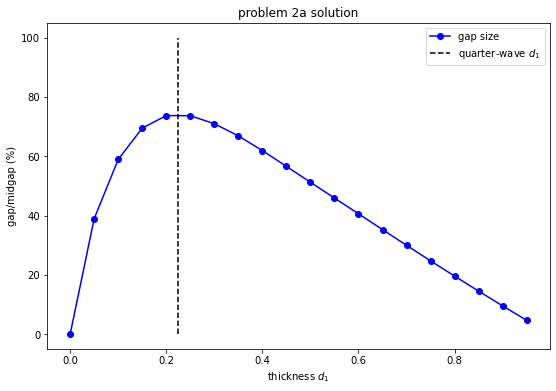

In [4]:
plt.figure(figsize=(9,6))
plt.plot(d1s, gaps, "bo-")

d1qw = math.sqrt(eps2) / (math.sqrt(eps1) + math.sqrt(eps2))
plt.plot([d1qw, d1qw], [0, 100], "k--")
plt.xlabel("thickness $d_1$")
plt.ylabel("gap/midgap (%)")
plt.legend(["gap size", "quarter-wave $d_1$"])
plt.title("problem 2a solution")

### part (b)

Plot the 1d TM band diagram for this structure, with $d_{1}$ given by the quarter wave thickness, showing the first five gaps. Also compute it for $d_{1}=0.12345$ (which I just chose randomly), and superimpose the two plots (plot the quarter-wave bands as solid lines and the other bands as dashed). What special features does the quarter-wave band diagram have?

In [ ]:
ms.num_bands = 10 # 10 bands for first 5 gaps

# quarter-wave d1 from above:
ms.geometry=[mp.Block(center=(0,0,0), size=(d1qw,mp.inf,mp.inf),
                      material=mp.Medium(epsilon=eps1))]
ms.run_tm()
freqs_qw = ms.all_freqs    # save the computed frequencies

# d1 = 0.12345
ms.geometry=[mp.Block(center=(0,0,0), size=(0.12345,mp.inf,mp.inf),
                      material=mp.Medium(epsilon=eps1))]
ms.run_tm()
freqs_12345 = ms.all_freqs # save the computed frequencies

Now, we plot the bands for the two values of $d_1$.   If we look *very* carefully, we can notice *three* special things about the quarter-wave bands:

* There are no gaps at $k=0$, where an *accidental degeneracy* occurs for the quarter-wave structure.  (The $d_1 = 0.12345a$ structure *almost* has an accidental degeneracy at $k = pi/a$ between its third and fourth bands, but there is actually a very small gap there.)
* The quarter-wave gaps $\Delta\omega$ (opening at $k=\pi/a$) are all exactly the same size (in absolute units, not as a fraction of mid-gap).
* The quarter-wave mid-gap frequencies are spaced exactly at the *odd-integer multiples* of the first mid-gap $\omega$!  (The gaps are equally spaced in $\omega$.)

(0.0, 0.5)

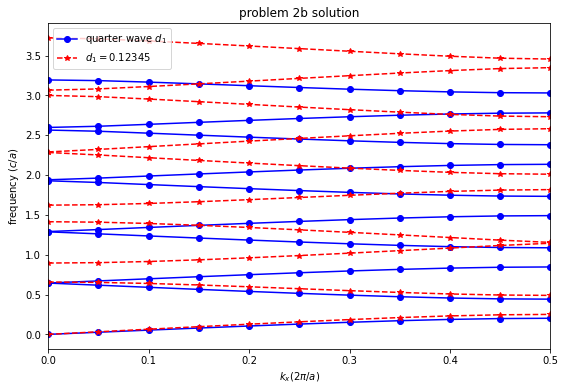

In [6]:
kx_qw = [k.x for k in ms.k_points] # get a list of the kx values
plt.figure(figsize=(9,6))
plt.plot(kx_qw, freqs_qw, "bo-")[0].set_label("quarter wave $d_1$")
plt.plot(kx_qw, freqs_12345, "r*--")[0].set_label("$d_1=0.12345$")
plt.title("problem 2b solution")
plt.xlabel("$k_x (2\pi/a)$")
plt.ylabel("frequency $(c/a)$")
plt.legend()
plt.xlim(0,0.5)

## Problem 3: Defect modes in MPB

Here, you will create a ($E_z$/TM-polarized) "defect" mode by increasing the dielectric constant of a single layer by $\Delta\varepsilon$, pulling an eigenvalue down into the gap. The periodic structure will be the same as the one from the problem above, with the quarter-wave thickness $d_{1}=1/(1+\sqrt{12})$.

To model a defect in MPB, we have to use a "supercell" with N copies of the unit cell, where one of the copies has been changed.  This also means that we need to compute N times as many bands, because of the "band folding" (the reduction of the Brillouin zone).

For convenience, we'll define a function `supercell1(N, deps1)` Python function that sets up our `ModeSolver` object for a given N and $\Delta\varepsilon_1$:

In [7]:
# define a function to create a supercell in the eps1 layer, with some default parameters:
def supercell1(N=15, deps1=0, eps1=12, eps2=1, tol=1e-8):
    d1 = math.sqrt(eps2) / (math.sqrt(eps1) + math.sqrt(eps2)) # quarter-wave thickness
    d2 = 1 - d1
    return mpb.ModeSolver(                    
        # unit cell a supercell: size N in x direction (and zero size in y and z).
        geometry_lattice=mp.Lattice(size=(N,0,0)),
        tolerance=tol,

        # To create the supercell geometry, we have to repeat the eps1 block N times,
        # and we can do this using the geometric_objects_lattice_duplicates function.
        # 
        # To create the defect, we'll simply append
        # a new object with eps1 + deps1 at the end of the geometry list
        # -- note that later objects take precedence over earlier objects,
        #    so by putting it at the end we ensure that the defect "overwrites"
        #    the whatever was previously there.
        geometry=mp.geometric_objects_lattice_duplicates(
                    mp.Lattice(size=(N,0,0)),
                    [mp.Block(center=(0,0,0), size=(d1,mp.inf,mp.inf),
                              material=mp.Medium(epsilon=eps1))]) +
                 [mp.Block(center=(0,0,0), size=(d1,mp.inf,mp.inf),
                           material=mp.Medium(epsilon=eps1+deps1))],
        
        default_material=mp.Medium(epsilon=eps2),

        # for computing a defect mode, k doesn't matter (if N is big enough),
        # so we'll just set k = 0
        k_points=[mp.Vector3(0)],

        resolution=32, # this is plenty for the first few bands
        
        # because of the folding, the first band (before the gap) will be folded
        # N times.  So, we need to compute N bands plus some extra bands to
        # get whatever defect states lie in the gap.  We'll just use 1 extra band,
        # but you'll need to increase this to see higher-order defect modes.
        num_bands=N+1
        )

## part (a)

When there is no defect ($\Delta\varepsilon = 0$), plot out the band diagram $\omega(k)$ for the $N=5$ supercell, and show that it corresponds to the band diagram of problem 2 “folded” as expected.

You'll want to change `N` to `5`, and also change the k points to an array:

In [ ]:
sc = supercell1(N=5, deps1=0)

# Compute the band structure for an array of k points.  Note that the k points
# are in units of the reciprical lattice, so kx=0.5 is still the edge of the 
# Brillouin zone (but is not the same kx=pi/a!).
sc.k_points = mp.interpolate(19, [mp.Vector3(0), mp.Vector3(0.5)])

# compute some more bands so that we get a clear picture of what is going on
sc.num_bands = 20

sc.run_tm()

Here, we plot the "folded" bands of the supercell and superimpose the "unfolded" bands of the unit cell computed above.

A key point to be careful of is that the units of $k$ are different in the two cases, because MPB's $k$ is in **units of the reciprocal lattice vectors**.  For the unit cell, $k$ is in units of $2\pi/a$ where $a$ is the period, but for the supercell $k$ is in units of $2\pi/Na$.  So, to put them on the same plot we need to **divide the supercell** $k$ values by $N=5$:

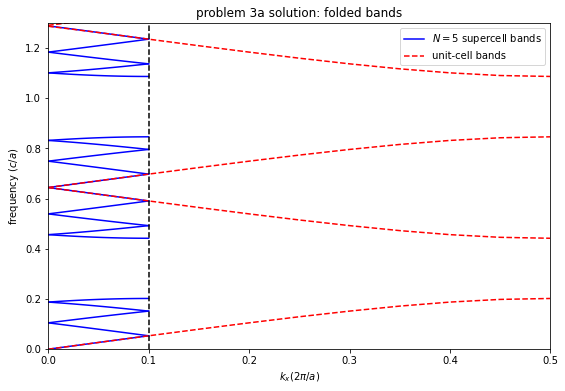

In [9]:
kx = [k.x/5 for k in sc.k_points]
freqs = sc.all_freqs

plt.figure(figsize=(9,6))
plt.plot(kx, freqs, "b-")[0].set_label("$N=5$ supercell bands")
plt.title("problem 3a solution: folded bands")
plt.xlabel("$k_x (2\pi/a)$")
plt.ylabel("frequency $(c/a)$")
plt.xlim(0,0.5)
plt.ylim(0,1.3)
plt.plot([0.1, 0.1], [0, 2], "k--")

plt.plot(kx_qw, freqs_qw, "r--")[0].set_label("unit-cell bands")
plt.legend()

Plotted in this way, it is pretty clear that the supercell (blue) bands are simply the unit cell (dashed red) bands "folded" into the smaller Brillouin zone of the supercell.

### part (b)

Create a defect mode (a mode that lies in the band gap of the periodic structure) by increasing the $\varepsilon$ of a single $\varepsilon_{1}$ layer by $\Delta\varepsilon=1$, and plot the $E_{z}$ field pattern. Do the same thing by increasing a single $\varepsilon_{2}$ layer. Which mode is even/odd around the mirror plane of the defect? Why?

For the $\Delta\varepsilon_1$ layer, we can use our `supercell1` function from above:

In [ ]:
N = 100

sc = supercell1(N=N, deps1=1)
sc.run_tm(mpb.fix_efield_phase)

Text(0.5, 0, '$x (a)$')

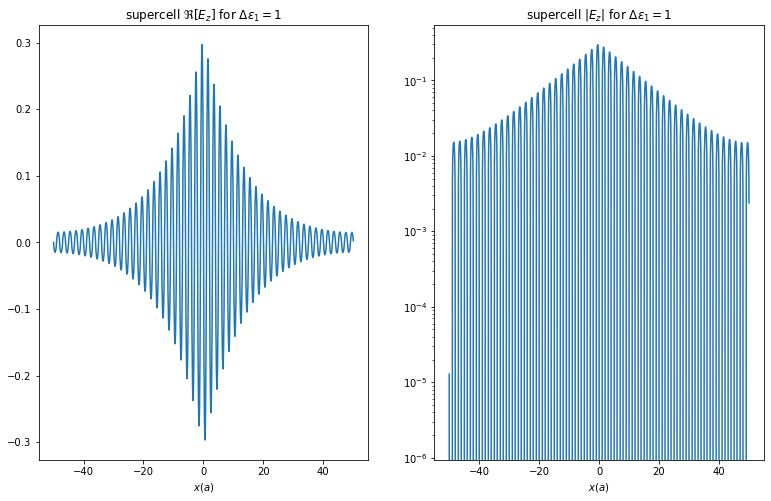

In [11]:
# get the Ez field of band N+1, which should be the mode in the gap for deps1 > 0
ez = sc.get_efield(N+1)[:,0,0,2]

x = np.linspace(-N/2, N/2, N*sc.resolution[0])

# for fun, we'll plot on both a linear and a log scale
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x, np.real(ez))
plt.title("supercell $\Re[E_z]$ for $\Delta\epsilon_1 = 1$")
plt.xlabel("$x (a)$")
plt.subplot(1,2,2)
plt.semilogy(x, np.real(ez))
plt.title("supercell $|E_z|$ for $\Delta\epsilon_1 = 1$")
plt.xlabel("$x (a)$")

### part (b) continued

Now, to do the same thing but for $\Delta\varepsilon_2 = 1$, we'll just call the `supercell1` function and $\varepsilon_1$ and $\varepsilon_2$:

In [12]:
# define a function to create a supercell in the eps2 layer, with some default parameters:
def supercell2(N=15, deps2=0, eps1=12, eps2=1, tol=1e-8):
    return supercell1(N, deps1=deps2, eps1=eps2, eps2=eps1, tol=tol)

In [ ]:
sc2 = supercell2(N=N, deps2=1, tol=1e-13)
sc2.run_tm(mpb.fix_efield_phase)

Text(0.5, 0, '$x (a)$')

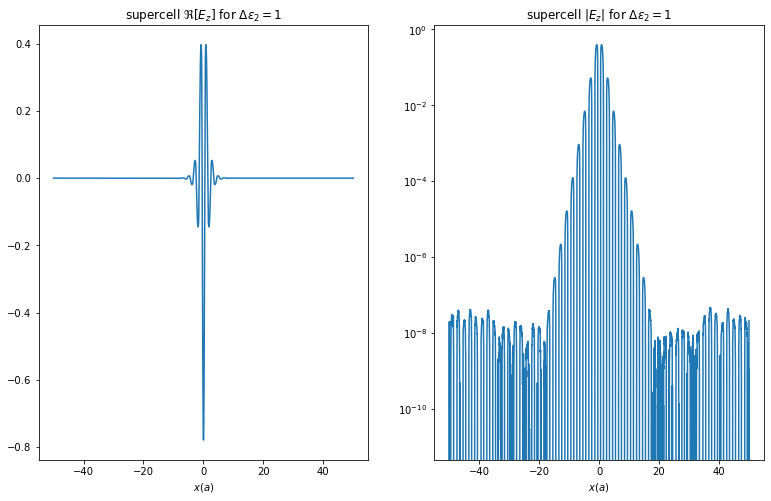

In [14]:
# get the Ez field of band N+1, which should be the mode in the gap for deps1 > 0
ez2 = sc2.get_efield(N+1)[:,0,0,2]

x = np.linspace(-N/2, N/2, N*sc2.resolution[0])

# for fun, we'll plot on both a linear and a log scale
plt.figure(figsize=(13,8))
plt.subplot(1,2,1)
plt.plot(x, np.real(ez2))
plt.title("supercell $\Re[E_z]$ for $\Delta\epsilon_2 = 1$")
plt.xlabel("$x (a)$")
plt.subplot(1,2,2)
plt.semilogy(x, np.real(ez2))
plt.title("supercell $|E_z|$ for $\Delta\epsilon_2 = 1$")
plt.xlabel("$x (a)$")

As desired, both the $\Delta\varepsilon_1$ and $\Delta\varepsilon_2$ defects "pulled" an eigenvalue down into the gap, creating a "bound" or "cavity" mode solution that is *exponentially* localized.   (In the $\Delta\varepsilon_2$ case, the exponential tails turn into numerical noise once they get sufficiently small, since MPB only computes the eigenvalues to a certain accuracy and the tails have exponentially small effect on $\omega$.)

To compare the symmetry of the two modes, we should plot them next to one another in a smaller $x$ range:

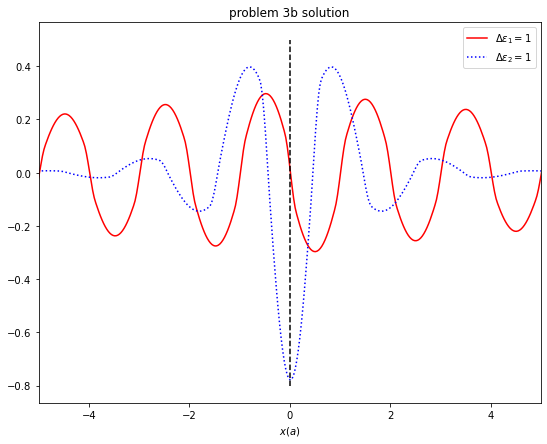

In [15]:
x = np.linspace(-N/2, N/2, N*sc2.resolution[0])

plt.figure(figsize=(9,7))
plt.plot(x, np.real(ez), "r-")
plt.plot(x, np.real(ez2), "b:")
plt.title("problem 3b solution")
plt.xlabel("$x (a)$")
plt.legend(["$\Delta\epsilon_1 = 1$", "$\Delta\epsilon_2 = 1$"])
plt.xlim(-5,5)
plt.plot([0,0], [-0.8,0.5], "k--")

How do we understand the symmetry here?   In both cases, the $\varepsilon(x)$ function is mirror-symmetric around the defect, so we *expect even/odd solutions*.  But which one?

We are "pulling" down a mode from the *top* of the gap, and we saw in class (via perturbation theory) the band-edge mode at the *top* of the gap has an $E_z$ field that is *odd* in the $\varepsilon_1=12$ layer and *even* in the $\varepsilon_1=1$ layer.

Therefore, we expect the $\Delta\varepsilon_1$ defect mode to be *odd* around its center (= center of $\varepsilon_1$ layer), and the $\Delta\varepsilon_2$ mode should conversely be even around its center (= center of $\varepsilon_2$ layer), just like the band-edge mode it comes from.  This is exactly what we see in the plot above!

The fact that the $\Delta\varepsilon_1$ case has a node right in the middle of the defect layer also means that its $|E_z|$ field is smaller in the defect.  From perturbation theory, this means that the $\Delta\varepsilon_1$ defect has a *smaller effect* than the $\Delta\varepsilon_2$ defect: the $\Delta\varepsilon_1$ defect doesn't "push" the mode as far into the gap, resulting in the **dramatically weaker confinement** apparent in the plots above.

### part (c)

Gradually increase the $\varepsilon$ of a single $\varepsilon_{2}$ layer, and plot the defect $\omega$ as a function of $\Delta\varepsilon_2$ as the frequency sweeps across the gap. At what $\Delta\varepsilon_2$ do you get two defect modes in the gap? Plot the $E_{z}$ of the second defect mode.

Be careful to increase the size of the supercell for modes near the edge of the gap, which are only weakly localized.  We will need to increase `num_bands` by 1 in order to see a second mode in the gap (if any).

We will just write a loop using our `supercell2` function, scanning from $\Delta\varepsilon_2 = 0$ to $30$.

In [ ]:
# our array of Δε₂ values from 0 to 30;
# we put some more data points near Δε₂=0 for a nicer plot
deps2s = np.concatenate([np.linspace(0, 5, 20), np.linspace(5 + 5/20, 30, 30)])

# frequencies of the first and second modes
freq1 = []
freq2 = []

# estimated decay rates, for the next problem
kappas = []

N=100
x = N/2 + 5

for deps2 in deps2s:
    s = supercell2(N=N, deps2=deps2)
    s.num_bands=N+2
    s.run_tm()
    ez = s.get_efield(N+1)[:,0,0,2]
    kappa = math.log(np.abs(ez[int(x*s.resolution[0])]/ez[int((x+1)*s.resolution[0])]))
    kappas = kappas + [kappa]
    freq1 = freq1 + [s.all_freqs[-1,-2]]
    freq2 = freq2 + [s.all_freqs[-1,-1]]

Finally, let's plot the results, superimposing the band gap:

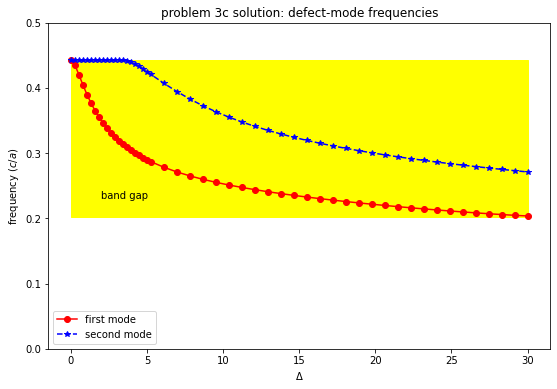

In [17]:
plt.figure(figsize=(9,6))
plt.plot(deps2s, freq1, "ro-")
plt.plot(deps2s, freq2, "b*--")
plt.xlabel("$\Delta\varepsilon_2$")
plt.ylabel("frequency $(c/a)$")
plt.title("problem 3c solution: defect-mode frequencies")
plt.fill([0,30,30,0], [freqs_qw[-1,0],freqs_qw[-1,0],freqs_qw[-1,1],freqs_qw[-1,1]], color="yellow")
plt.ylim(0,0.5)
plt.text(2,0.23,"band gap")
plt.legend(["first mode", "second mode"])

The above figure shows ω as a function of ∆ε of the first two defect modes, where the second defect mode appears in the gap at $\Delta\varepsilon_2 \approx 4.8$. As it turned out, I needed to go to larger values of ∆ε, all the way to ∆ε = 30, in order for the first defect mode to reach the lower edge of the gap.

Below, we plot the $E_z$ field of the first and second defect modes at $\Delta\varepsilon_2 = 10$:

In [ ]:
s = supercell2(N=N, deps2=10)
s.num_bands=N+2
s.run_tm(mpb.fix_efield_phase)

Text(0, 0.5, '$E_z$ (normalized)')

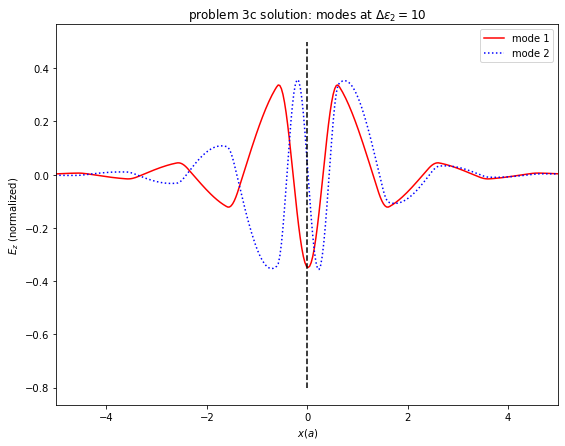

In [19]:
ez1 = s.get_efield(N+1)[:,0,0,2]
ez2 = s.get_efield(N+2)[:,0,0,2]

x = np.linspace(-N/2, N/2, N*s.resolution[0])

plt.figure(figsize=(9,7))
plt.plot(x, np.real(ez1), "r-")
plt.plot(x, np.real(ez2), "b:")
plt.title("problem 3c solution: modes at $\Delta\epsilon_2 = 10$")
plt.xlabel("$x (a)$")
plt.legend(["mode 1", "mode 2"])
plt.xlim(-5,5)
plt.plot([0,0], [-0.8,0.5], "k--")
plt.ylabel("$E_z$ (normalized)")

As can be seen from the above plot, the new mode introduced by this large $\Delta\varepsilon_2=10$ is indeed localized and orthogonal to the first mode (odd where the first mode is even).

### part (d)

The mode must decay exponentially far from the defect (multiplied by an $e^{i\frac{\pi}{a}x}$ sign oscillation and the periodic Bloch envelope, of course). From the $E_{z}$ field computed by MPB, extract this asympotic exponential decay rate (i.e. $\kappa$ if the field decays $\sim e^{-\kappa x}$) and plot this rate as a function of $\omega$, for the first defect mode, as you increase $\varepsilon_{2}$ as above (vary $\varepsilon_{2}$ so that $\omega$ goes from the top of the gap to the bottom).

The supercell size $N=100$ from above is more than sufficient for our purposes.  As seen in the first part of the problem, the rapid decay of the modes means that looking at about $x = 5a$ seems like it should give us a good estimate of the decay rate.  (Looking at much larger $x$ than this risks going into the "noise floor" of the mode that we saw in the first part.)

We will use the estimate $$\kappa \approx \log|E_z(x)/E_z(x+a)|$$ for $x = 5a$.  From our Python `ez` array, we can compute `kappa = math.log(np.abs(ez[x*resolution]/ez[(x+1)*resolution]))` for `x = N/2 + 5`.   This is implemented in the code for the previous part of the problem above.

(0.0, 1.3)

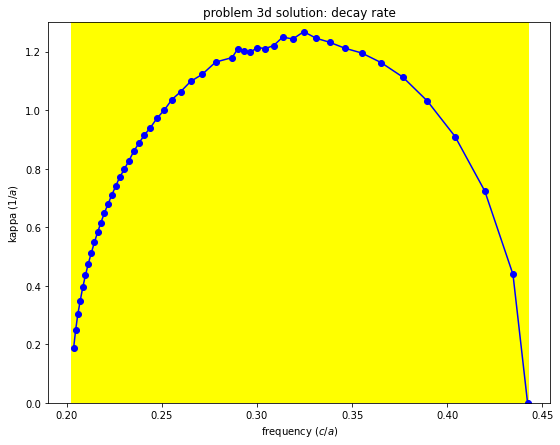

In [20]:
plt.figure(figsize=(9,7))
plt.plot(freq1, kappas, "bo-")
plt.xlabel("frequency $(c/a)$")
plt.ylabel("kappa $(1/a)$")
plt.title("problem 3d solution: decay rate")

plt.fill([freqs_qw[-1,0],freqs_qw[-1,0],freqs_qw[-1,1],freqs_qw[-1,1]], [0, 1.3, 1.3, 0], color="yellow")
plt.ylim(0,1.3)

The resulting $\kappa(\omega)$ is plotted in above. Just as we predicted in class, it increases as $\sqrt{\Delta\omega}$ (i.e. in a sideways parabola) away from the gap edges, and peaks in the center of the gap! 

(The fact that it turns out to peak exactly at the center of the gap is a special property of the quarter-wave stack, and is not true in general for photonic crystals.)